## Example of performing an FFT in Python.

Jon Richards - January 08, 2023

In [1]:
#%matplotlib notebook
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import scipy.fftpack
from scipy.signal import argrelextrema
from scipy import signal

from datetime import datetime as dt

from pylab import rcParams

import os
rcParams['figure.figsize'] = 15, 9

In [2]:
def readBlock(file, num_samples):
    """ 
    Read the next FFT sized block of 16-bit I/Q data from an opened file.
    
    Arguments:
        file - The reference to the data file, already opened.
        num_samples - The number of 16-bit I/Q samples to read in.
            Example, If you FFT SIZE is 1024, the num_samples should
            be 1024. 2048 16-bit samples (4096 bytes total) will be 
            read and unpacked from the file.
            
        Return - A Numpy array of "num_samples" Complex64 values.
            None if the read is past the end of the file.
    
    """
    # Read the bytes from the file
    data_raw = np.fromfile(file, dtype=np.int16, count=num_samples*2)
    
    # Create a Complex64 Numpy array to hold the values
    data = np.zeros((num_samples,), dtype=np.complex64)
    
    # Reassemble the int16 aray into the Complex64 array.
    # Use a try block to catch the condition where the end of the file
    # has been passed.
    try:
        data[:] = (data_raw[0::2]) + 1j*(data_raw[1::2])
    except:
        return None
    
    return data

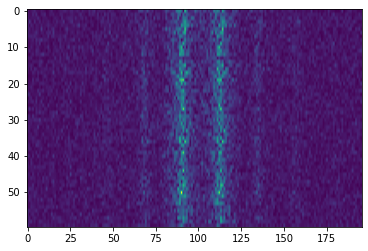

In [3]:
# Set this to False to disable the plotting of the spectrum and
# instead display the waterfall using plt.imshow.
PLOT_SPECTRUM = False

# Open the file
data_file_path = os.path.join("./data", "raw_int16_iq.dat")
file = open(data_file_path, "rb")

FFT_SIZE = 1920000
#CENTER_FREQ_HZ = 1296000000
BANDWIDTH_HZ   = 1920000
MHZ = 1048576.0

START_CHAN = 1211289 -50
END_CHAN = 1211385 + 50

#START_CHAN = 0
#END_CHAN = 1920000

# Create an array to hold the accumulation for each bin
fft_acc = np.zeros((FFT_SIZE, ))

NUM = 60

if PLOT_SPECTRUM is False:
    row_data = []

# Loop through the file. 
for i in range(NUM):
        #if count % 100000 == 0:
    #    print(count)
    
    # Read the next block of data from the file
    d = readBlock(file, FFT_SIZE)
    
    # If None is retruned, this signifies we read to the end of the file.
    # Break out of the loop.
    if d is None:
        break
        
    # Perform the FFT
    yf = scipy.fftpack.fft(d, n=FFT_SIZE, axis=0)
    
    # Add the results of the FFTp to the fft_acc Numpy array
    #np.add(np.abs(yf[START_CHAN:END_CHAN]), fft_acc, out=fft_acc)
    np.add(np.abs(yf), fft_acc, out=fft_acc)

    if PLOT_SPECTRUM is False:
        xx = np.abs(yf).tolist()
        yy = scipy.fft.fftshift(xx)
        row_data.append(yy[START_CHAN:END_CHAN])
    
# Make sure to close the file!
file.close()

# A strange artifact of the FFTp process is that the upper and lower
# halved are swapped. The fftshift swaps them back to the correct order.
fft_acc_temp = scipy.fft.fftshift(fft_acc) 
fft_acc = fft_acc_temp[START_CHAN:END_CHAN]

# Draw a plot of the results
fig, ax = plt.subplots(1,1)

if PLOT_SPECTRUM is False:
    plt.imshow(row_data, aspect='auto', cmap=plt.get_cmap("viridis"))
else:
    ax.plot( fft_acc)

plt.show()